# Load Data

In [21]:
!pip install wandb

In [2]:
!pip install datasets

In [3]:
!pip install underthesea

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from underthesea import pos_tag
from difflib import SequenceMatcher
from collections import Counter
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, classification_report
import torch
import os
from datasets import Dataset, DatasetDict, load
from sklearn.model_selection import train_test_split
from collections import defaultdict
from joblib import Parallel, delayed

In [5]:
df = pd.read_excel('/content/ViLegalNLI.xlsx')

In [6]:
df.head(3)

Hypothesis  \
0  C∆° quan kho b·∫°c nh√† n∆∞·ªõc ph·∫£i th·ª±c hi·ªán vi·ªác t...   
1  Quy·∫øt ƒë·ªãnh n√†y c√≥ th·ªÉ ƒë·∫øn t·ª´ m·ªôt s·ª± thay ƒë·ªïi t...   
2  ·ª¶y ban nh√¢n d√¢n huy·ªán C·∫ßn Gi·ªù kh√¥ng c√≥ tr√°ch n...   

                                             Premise  \
0  4. C∆° quan kho b·∫°c nh√† n∆∞·ªõc c√≥ tr√°ch nhi·ªám a T...   
1  4. C∆° quan kho b·∫°c nh√† n∆∞·ªõc c√≥ tr√°ch nhi·ªám a T...   
2  4. C∆° quan kho b·∫°c nh√† n∆∞·ªõc c√≥ tr√°ch nhi·ªám a T...   

                                                Text              Aspect  \
0  QUY·∫æT ƒê·ªäNH QUY ƒê·ªäNH V·ªÄ M·ª®C THU TI·ªÄN S·ª¨ D·ª§NG KH...  t√†i ch√≠nh nh√† n∆∞·ªõc   
1  QUY·∫æT ƒê·ªäNH QUY ƒê·ªäNH V·ªÄ M·ª®C THU TI·ªÄN S·ª¨ D·ª§NG KH...  t√†i ch√≠nh nh√† n∆∞·ªõc   
2  QUY·∫æT ƒê·ªäNH QUY ƒê·ªäNH V·ªÄ M·ª®C THU TI·ªÄN S·ª¨ D·ª§NG KH...  t√†i ch√≠nh nh√† n∆∞·ªõc   

                       Website  Label  \
0  https://thuvienphapluat.vn/      0   
1  https://thuvienphapluat.vn/      1   
2  https://thuvienphapluat.vn/      2   

                                       List Evidence  \
0  "Kh√¥ng ƒë∆∞·ª£c chuy·ªÉn vi·ªác thu ti·ªÅn sang ng√†y h√¥m...   
1                                                NaN   
2  "·ª¶y ban nh√¢n d√¢n huy·ªán C·∫ßn Gi·ªù c√≥ tr√°ch nhi·ªám ...   

                                         Explanation  \
0  B·∫±ng ch·ª©ng ch·ªâ ra r√µ r√†ng r·∫±ng c∆° quan kho b·∫°c...   
1  N·ªôi dung kh√¥ng ƒë·ªÅ c·∫≠p ƒë·∫øn l√Ω do c·ª• th·ªÉ t·∫°i sao...   
2  B·∫±ng ch·ª©ng cho th·∫•y r√µ r√†ng r·∫±ng ·ª¶y ban nh√¢n d...   

                                           File Path  Text Length  
0  /content/drive/MyDrive/[DS201 + DS310] ƒêOÃÇÃÄ AÃÅ...         2232  
1  /content/drive/MyDrive/[DS201 + DS310] ƒêOÃÇÃÄ AÃÅ...         2232  
2  /content/drive/MyDrive/[DS201 + DS310] ƒêOÃÇÃÄ AÃÅ...         2232

In [7]:
def split_data(df, test_size=0.1, dev_size=0.1):
    grouped = list(df.groupby('Text'))
    train_groups, temp_groups = train_test_split(grouped, test_size=(test_size + dev_size), random_state=42)
    dev_size_adjusted = dev_size / (test_size + dev_size)
    dev_groups, test_groups = train_test_split(temp_groups, test_size=1 - dev_size_adjusted, random_state=42)
    def flatten(groups):
        return pd.concat([group for _, group in groups])
    train_df = flatten(train_groups)
    dev_df = flatten(dev_groups)
    test_df = flatten(test_groups)
    return train_df, dev_df, test_df

# EDA

In [ ]:
print('C√°c c·ªôt c·ªßa d·ªØ li·ªáu:')
df.columns

C√°c c·ªôt c·ªßa d·ªØ li·ªáu:


Index(['Hypothesis', 'Premise', 'Text', 'Aspect', 'Website', 'Label',
       'List Evidence', 'Explanation', 'File Path', 'Text Length'],
      dtype='object')

In [ ]:
df.shape

(9696, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9696 entries, 0 to 9695
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Hypothesis     9683 non-null   object
 1   Premise        9672 non-null   object
 2   Text           9696 non-null   object
 3   Aspect         9696 non-null   object
 4   Website        9696 non-null   object
 5   Label          9696 non-null   int64 
 6   List Evidence  6455 non-null   object
 7   Explanation    9683 non-null   object
 8   File Path      9696 non-null   object
 9   Text Length    9696 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 757.6+ KB


In [ ]:
df['Text Length'].describe()

count    9696.000000
mean     2379.910994
std      2144.164501
min        33.000000
25%       828.000000
50%      1361.000000
75%      3431.000000
max      8285.000000
Name: Text Length, dtype: float64

In [ ]:
# Ki·ªÉm tra gi√° tr·ªã tr√πng nhau
print('S·ªë gi√° tr·ªã tr√πng nhau c·ªßa b·ªô d·ªØ li·ªáu:',df.duplicated().sum())

S·ªë gi√° tr·ªã tr√πng nhau c·ªßa b·ªô d·ªØ li·ªáu: 0


In [ ]:
def missing_values_table(df):
    if df.isnull().sum().any():
        print('S·ªë gi√° tr·ªã khuy·∫øt c·ªßa b·ªô d·ªØ li·ªáu:')
        print(df.isnull().sum())
    else:
        print('B·ªô d·ªØ li·ªáu kh√¥ng c√≥ gi√° tr·ªã khuy·∫øt')

In [ ]:
missing_values_table(df)

S·ªë gi√° tr·ªã khuy·∫øt c·ªßa b·ªô d·ªØ li·ªáu:
Hypothesis         13
Premise            24
Text                0
Aspect              0
Website             0
Label               0
List Evidence    3241
Explanation        13
File Path           0
Text Length         0
dtype: int64


In [8]:
# X·ª≠ l√Ω gi√° tr·ªã khuy·∫øt
df.dropna(subset = ['Premise', 'Hypothesis', 'Explanation'], inplace = True)

In [ ]:
df.shape

(9667, 10)

In [ ]:
missing_values_table(df)

S·ªë gi√° tr·ªã khuy·∫øt c·ªßa b·ªô d·ªØ li·ªáu:
Hypothesis          0
Premise             0
Text                0
Aspect              0
Website             0
Label               0
List Evidence    3223
Explanation         0
File Path           0
Text Length         0
dtype: int64


In [9]:
# H√†m ƒë·∫øm s·ªë t·ª´ trong c√¢u
def count_words(sentence):
    return len(sentence.split())

# ƒê·∫øm s·ªë t·ª´ trong t·ª´ng c√¢u c·ªßa c·ªôt 'Premise' v√† 'Hypothesis'
df['Premise_Length'] = df['Premise'].apply(count_words)
df['Hypothesis_Length'] = df['Hypothesis'].apply(count_words)

In [10]:
train_df, dev_df, test_df = split_data(df)

In [ ]:
def create_hypothesis_table(train, dev, test, group_by):
    # T√≠nh t·ªïng s·ªë t·ª´
    train_count = train.groupby(group_by).agg({'Hypothesis_Length': 'sum'}).rename(columns={'Hypothesis_Length': 'Hypothesis_Train'})
    dev_count = dev.groupby(group_by).agg({'Hypothesis_Length': 'sum'}).rename(columns={'Hypothesis_Length': 'Hypothesis_Dev'})
    test_count = test.groupby(group_by).agg({'Hypothesis_Length': 'sum'}).rename(columns={'Hypothesis_Length': 'Hypothesis_Test'})

    # H·ª£p nh·∫•t
    merged = train_count.merge(dev_count, left_index=True, right_index=True)
    merged = merged.merge(test_count, left_index=True, right_index=True)
    merged['Total'] = merged.sum(axis=1)

    return merged.reset_index()

In [ ]:
# T·∫°o b·∫£ng Hypothesis cho Aspect v√† Label
hypothesis_aspect_table = create_hypothesis_table(train_df, dev_df, test_df, 'Aspect')
hypothesis_label_table = create_hypothesis_table(train_df, dev_df, test_df, 'Label')

In [ ]:
hypothesis_aspect_df = pd.DataFrame(hypothesis_aspect_table)
hypothesis_label_df = pd.DataFrame(hypothesis_label_table)

print("Hypothesis Table (Aspect):")
hypothesis_aspect_df

Hypothesis Table (Aspect):


Aspect  Hypothesis_Train  Hypothesis_Dev  \
0              b·∫•t ƒë·ªông s·∫£n              4800             645   
1         b·ªô m√°y h√†nh ch√≠nh             67409            9349   
2               ch·ª©ng kho√°n              1227             193   
3       c√¥ng ngh·ªá th√¥ng tin              4164             738   
4              doanh nghi·ªáp              1375             319   
5                    d√¢n s·ª±              7071            1660   
6      giao th√¥ng - v·∫≠n t·∫£i             12018             724   
7                  gi√°o d·ª•c             10821             692   
8                      kh√°c             15501            1912   
9       k·∫ø to√°n - ki·ªÉm to√°n               715             266   
10    lao ƒë·ªông - ti·ªÅn l∆∞∆°ng              3296             396   
11           s·ªü h·ªØu tr√≠ tu·ªá              1423             315   
12      thu·∫ø - ph√≠ - l·ªá ph√≠              1963              75   
13               th∆∞∆°ng m·∫°i              1539             184   
14          th·ªÉ thao - y t·∫ø              6273             782   
15          th·ªß t·ª•c t·ªë t·ª•ng              3419             509   
16      ti·ªÅn t·ªá - ng√¢n h√†ng              3401             166   
17       t√†i ch√≠nh nh√† n∆∞·ªõc             15178            2825   
18  t√†i nguy√™n - m√¥i tr∆∞·ªùng              3789             351   
19       vi ph·∫°m h√†nh ch√≠nh              6428             427   
20         vƒÉn h√≥a - x√£ h·ªôi              2780             329   
21        x√¢y d·ª±ng - ƒë√¥ th·ªã              6863             905   
22                   ƒë·∫ßu t∆∞             14291            2372   

    Hypothesis_Test  Total  
0               679   6124  
1              8702  85460  
2               186   1606  
3               527   5429  
4               173   1867  
5               651   9382  
6               974  13716  
7              1554  13067  
8              2396  19809  
9               363   1344  
10              551   4243  
11              713   2451  
12              290   2328  
13              174   1897  
14              686   7741  
15              242   4170  
16               83   3650  
17             1289  19292  
18              557   4697  
19              986   7841  
20              148   3257  
21             1043   8811  
22             1755  18418

In [ ]:
print("\nHypothesis Table (Label):")
hypothesis_label_df


Hypothesis Table (Label):


Label  Hypothesis_Train  Hypothesis_Dev  Hypothesis_Test  Total
0      0             77274           10190             9842  97306
1      1             62526            8174             7897  78597
2      2             59342            7770             7488  74600

In [ ]:
sum_train = train_df['Hypothesis_Length'].sum()
sum_dev = dev_df['Hypothesis_Length'].sum()
sum_test = test_df['Hypothesis_Length'].sum()
sum_total = df['Hypothesis_Length'].sum()
print('Total')
print(f'Train: {sum_train}')
print(f'Dev: {sum_dev}')
print(f'Test: {sum_test}')
print(f'Data: {sum_total}')

Total
Train: 199142
Dev: 26134
Test: 25227
Data: 250503


In [ ]:
# T√≠nh MHL cho t·ª´ng t·∫≠p d·ªØ li·ªáu
mhl_train = train_df['Hypothesis_Length'].mean()
mhl_dev = dev_df['Hypothesis_Length'].mean()
mhl_test = test_df['Hypothesis_Length'].mean()
mhl_total = df['Hypothesis_Length'].mean()

print(f"MHL - Train: {mhl_train}")
print(f"MHL - Dev: {mhl_dev}")
print(f"MHL - Test: {mhl_test}")
print(f"MHL - Data: {mhl_total}")

MHL - Train: 25.892861786503705
MHL - Dev: 25.84965380811078
MHL - Test: 26.141968911917097
MHL - Data: 25.91320988931416


In [ ]:
# T√≠nh MPL cho t·ª´ng t·∫≠p d·ªØ li·ªáu
mpl_train = train_df['Premise_Length'].mean()
mpl_dev = dev_df['Premise_Length'].mean()
mpl_test = test_df['Premise_Length'].mean()
mpl_total = df['Premise_Length'].mean()

print(f"MPL - Train: {mpl_train}")
print(f"MPL - Dev: {mpl_dev}")
print(f"MPL - Test: {mpl_test}")
print(f"MPL - Data: {mpl_total}")

MPL - Train: 423.7845533740736
MPL - Dev: 420.21958456973294
MPL - Test: 426.06321243523314
MPL - Data: 423.6391848556946


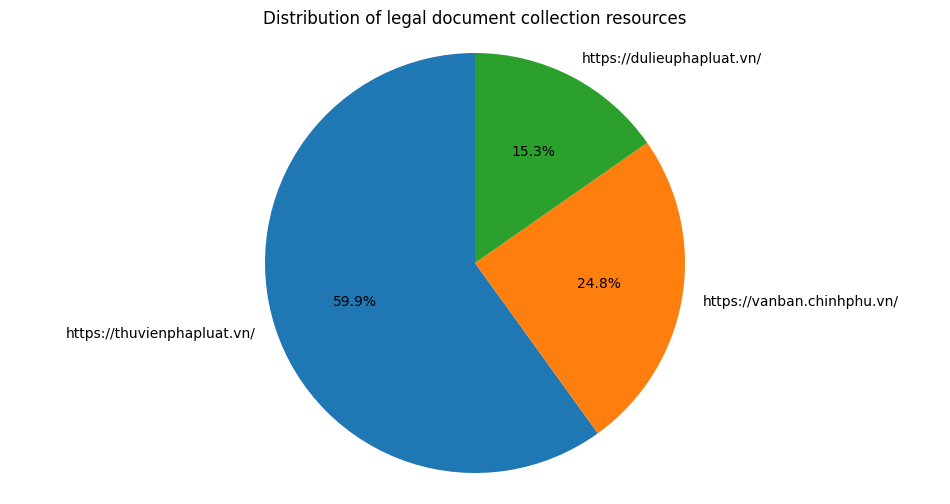

In [ ]:
website_counts = df['Website'].value_counts()

plt.figure(figsize=(12, 6))
plt.pie(website_counts, labels=website_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of legal document collection resources")
plt.axis('equal')
plt.show()

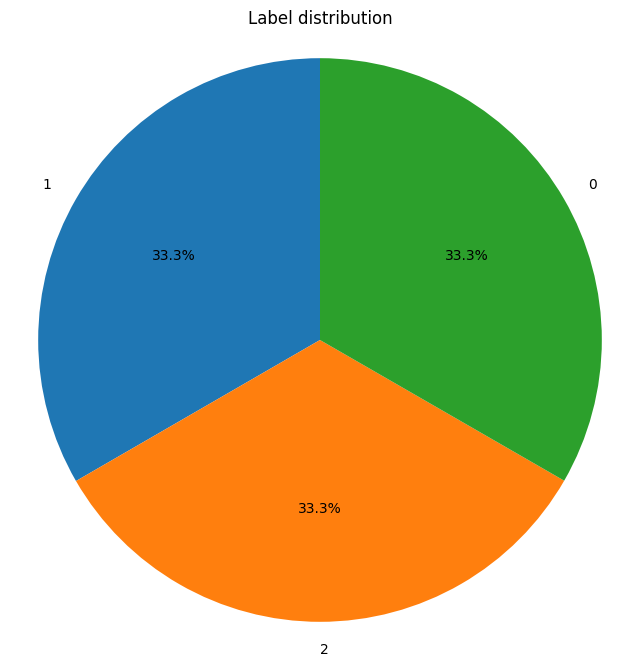

In [ ]:
# Ph√¢n ph·ªëi nh√£n
label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Label distribution')
plt.axis('equal')
plt.show()

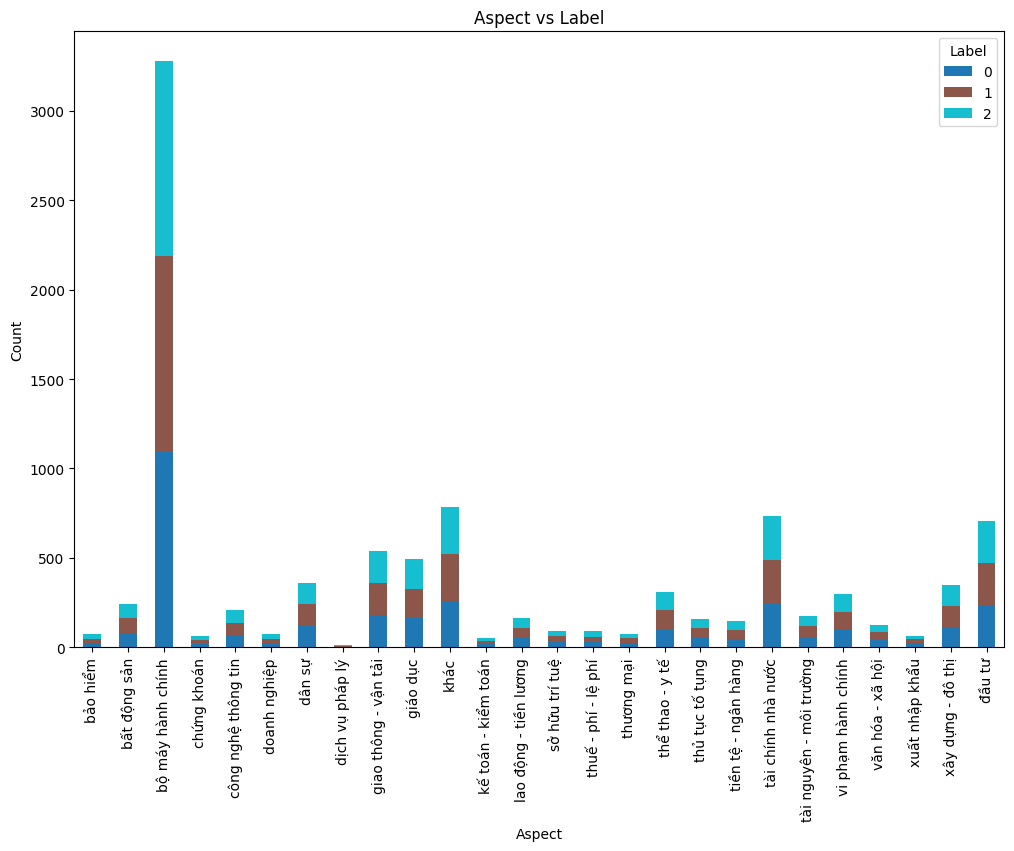

In [ ]:
# M·ªëi quan h·ªá gi·ªØa label v√† aspect
aspect_label_counts = df.groupby(['Aspect', 'Label']).size().unstack()
aspect_label_counts.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab10')
plt.title("Aspect vs Label")
plt.ylabel("Count")
plt.xlabel("Aspect")
plt.show()

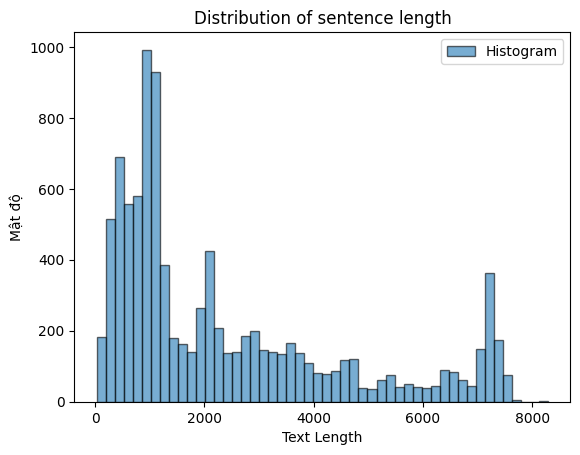

In [ ]:
plt.hist(df['Text Length'], bins=50, edgecolor='black', alpha=0.6, label="Histogram")

plt.xlabel('Text Length')
plt.ylabel('M·∫≠t ƒë·ªô')
plt.title("Distribution of sentence length")
plt.legend()
plt.show()

T·ªïng gi√° tr·ªã c·ªßa c√°c ch·ªß ƒë·ªÅ duy nh·∫•t: 26 



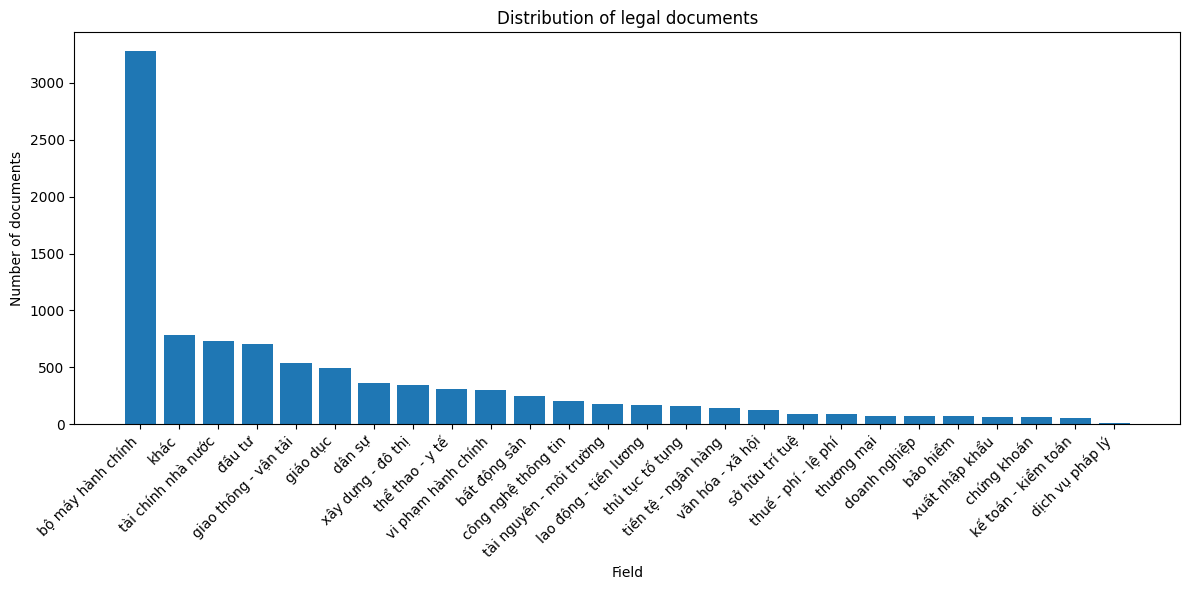

In [ ]:
# Ph√¢n ph·ªëi lƒ©nh v·ª±c vƒÉn b·∫£n lu·∫≠t
print('T·ªïng gi√° tr·ªã c·ªßa c√°c ch·ªß ƒë·ªÅ duy nh·∫•t:', df['Aspect'].nunique(),'\n')
aspect_counts = df['Aspect'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(aspect_counts.index, aspect_counts.values)
plt.xlabel("Field")
plt.ylabel("Number of documents")
plt.title("Distribution of legal documents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# World Cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

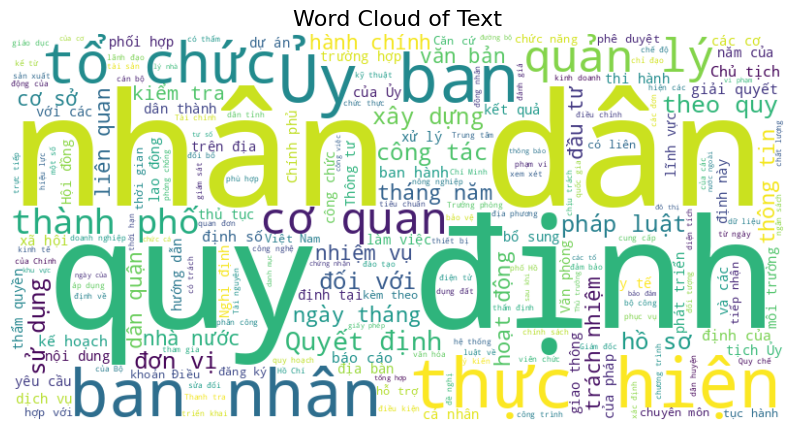

In [ ]:
plot_wordcloud(df['Text'], "Word Cloud of Text")

In [ ]:
# N-gram Analysis
def plot_ngrams(text, n=2, top_k=20):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(text)
    ngram_counts = ngrams.sum(axis=0)
    ngram_freq = [(word, ngram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]

    ngram_df = pd.DataFrame(ngram_freq, columns=['N-gram', 'Frequency'])
    sns.barplot(data=ngram_df, x='Frequency', y='N-gram', palette='viridis')
    plt.title(f'Top {top_k} {n}-grams')
    plt.show()

<ipython-input-37-3b55f212e673>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ngram_df, x='Frequency', y='N-gram', palette='viridis')


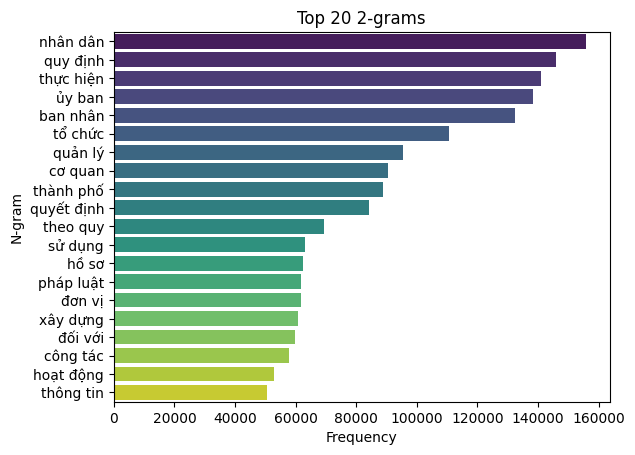

In [ ]:
plot_ngrams(df['Text'], n=2, top_k=20)

In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [ ]:
def new_word_rate(set1, set2):
    new_words = len(set2 - set1)
    return new_words / len(set2) if len(set2) != 0 else 0

In [ ]:
def longest_common_subsequence(str1, str2):
    seq_matcher = SequenceMatcher(None, str1, str2)
    return seq_matcher.find_longest_match(0, len(str1), 0, len(str2)).size

In [ ]:
def pos_distribution(text):
    pos_tags = pos_tag(text)
    pos_counts = Counter(tag for _, tag in pos_tags)
    total = sum(pos_counts.values())
    return {pos: (count / total) * 100 for pos, count in pos_counts.items()}

In [ ]:
jaccard_scores = []
new_word_rates = []
lcs_scores = []
pos_distributions = []

In [ ]:
for _, row in df.iterrows():
    premise = str(row['Premise'])
    hypothesis = str(row['Hypothesis'])

    premise_words = set(premise.split())
    hypothesis_words = set(hypothesis.split())

    # T√≠nh to√°n Jaccard v√† T·ª∑ l·ªá t·ª´ m·ªõi
    jaccard_scores.append(jaccard_similarity(premise_words, hypothesis_words))
    new_word_rates.append(new_word_rate(premise_words, hypothesis_words))

    # T√≠nh to√°n LCS
    lcs_scores.append(longest_common_subsequence(premise, hypothesis))

    # T√≠nh to√°n ph√¢n ph·ªëi POS
    pos_distributions.append(pos_distribution(hypothesis))

In [ ]:
data_summary = pd.DataFrame({
    'Label': df['Label'],
    'Jaccard': jaccard_scores,
    'New Word Rate': new_word_rates,
    'LCS': lcs_scores,
    'POS Distribution': pos_distributions
})

In [ ]:
# Tr√≠ch xu·∫•t ph·∫ßn trƒÉm POS ri√™ng l·∫ª
pos_tags = ["N", "V", "A", "P", "R", "X"]
for pos in pos_tags:
    data_summary[f"POS_{pos}"] = data_summary['POS Distribution'].apply(lambda x: x.get(pos, 0))

In [ ]:
summary = data_summary.groupby('Label').agg({
    'Jaccard': 'mean',
    'New Word Rate': 'mean',
    'LCS': 'mean',
    **{f"POS_{pos}": "mean" for pos in pos_tags}
}).reset_index()

In [ ]:
summary = summary.rename(columns={
    "POS_N": "Danh t·ª´",
    "POS_V": "ƒê·ªông t·ª´",
    "POS_A": "T√≠nh t·ª´",
    "POS_P": "ƒê·∫°i t·ª´",
    "POS_R": "Ph√≥ t·ª´",
    "POS_X": "Kh√°c"
})

In [ ]:
summary

Label   Jaccard  New Word Rate        LCS    Danh t·ª´    ƒê·ªông t·ª´   T√≠nh t·ª´  \
0      0  0.108432       0.260612  34.004036  36.879959  26.712625  4.241166   
1      1  0.074237       0.387026  27.660565  36.293087  24.357164  3.805218   
2      2  0.082238       0.293001  28.923984  34.723138  24.827583  3.255743   

     ƒê·∫°i t·ª´    Ph√≥ t·ª´      Kh√°c  
0  0.788143  3.309566  0.021528  
1  1.615545  7.161334  0.018154  
2  2.843682  8.291527  0.005205

# Training

## X√¢y d·ª±ng pipeline

In [11]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

def load_and_preprocess_data(train_df, dev_df, test_df, tokenizer):
    def preprocess_function(examples):
        # M√£ h√≥a Hypothesis v√† Premise
        tokenized = tokenizer(
            examples['Hypothesis'],  # T√™n c·ªôt Hypothesis trong DataFrame
            examples['Premise'],     # T√™n c·ªôt Premise trong DataFrame
            truncation=True,
            padding='max_length',
            max_length=512,          # Ch·ªânh s·ª≠a k√≠ch th∆∞·ªõc n·∫øu c·∫ßn
            return_tensors= 'pt'     # Lo·∫°i b·ªè return_tensors="pt" v√¨ Trainer y√™u c·∫ßu danh s√°ch/m·∫£ng
        )
        tokenized['labels'] = examples['Label']  # G√°n nh√£n v√†o c·ªôt labels
        return tokenized

    # Chuy·ªÉn DataFrame th√†nh Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # √Åp d·ª•ng ti·ªÅn x·ª≠ l√Ω v√† m√£ h√≥a d·ªØ li·ªáu
    encoded_train_dataset = train_dataset.map(lambda x: preprocess_function(x), batched=True)
    encoded_dev_dataset = dev_dataset.map(lambda x: preprocess_function(x), batched=True)
    encoded_test_dataset = test_dataset.map(lambda x: preprocess_function(x), batched=True)

    # Tr·∫£ v·ªÅ DatasetDict ch·ª©a c√°c dataset ƒë√£ m√£ h√≥a
    return DatasetDict({
        "train": encoded_train_dataset,
        "dev": encoded_dev_dataset,
        "test": encoded_test_dataset
    })

In [12]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)  # Precision (macro-average)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)  # Recall (macro-average)
    f1 = f1_score(labels, predictions, average='macro')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [13]:
def train_and_evaluate(model_name, dataset, num_labels=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Kh√¥ng c·∫ßn g·ªçi tokenizer.to(device) v√¨ tokenizer kh√¥ng s·ª≠ d·ª•ng GPU
    # Ch·ªâ c·∫ßn hu·∫•n luy·ªán m√¥ h√¨nh, m√¥ h√¨nh m·ªõi c·∫ßn ƒë∆∞·ª£c chuy·ªÉn sang GPU

    # Thi·∫øt l·∫≠p c√°c tham s·ªë hu·∫•n luy·ªán
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name.replace('/', '_')}",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    os.environ["WANDB_DISABLED"] = "true"  # T·∫Øt Weights & Biases

    # Hu·∫•n luy·ªán m√¥ h√¨nh v·ªõi Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['dev'],
        compute_metrics=compute_metrics,  # H√†m compute_metrics b·∫°n c·∫ßn ƒë·ªãnh nghƒ©a
    )

    # Hu·∫•n luy·ªán m√¥ h√¨nh
    trainer.train()
    torch.cuda.empty_cache()

    # ƒê√°nh gi√° m√¥ h√¨nh tr√™n dev v√† test
    dev_results = trainer.evaluate(dataset['dev'])
    test_results = trainer.evaluate(dataset['test'])

    # Tr·∫£ v·ªÅ k·∫øt qu·∫£ ƒë√°nh gi√° v√† m√¥ h√¨nh hu·∫•n luy·ªán
    return {
        'model_name': model_name,
        'dev_accuracy': dev_results['eval_accuracy'],
        'dev_f1': dev_results['eval_f1'],
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'trainer': trainer,
        'model': model
    }

In [14]:
# ƒê√°nh gi√° theo t·ª´ng label
def evaluate_per_label(labels, predictions):
    report = classification_report(labels, predictions, target_names=["Label 0", "Label 1", "Label 2"])  # C·∫≠p nh·∫≠t t√™n label n·∫øu c·∫ßn
    print("ƒê√°nh gi√° theo t·ª´ng label:\n", report)

In [15]:
def evaluate_per_aspect(df, predictions):
    # Ki·ªÉm tra v√† chuy·ªÉn ƒë·ªïi `Dataset` sang pandas DataFrame n·∫øu c·∫ßn
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    # Th√™m c·ªôt 'Predicted' v√†o DataFrame
    df['Predicted'] = predictions

    # Duy·ªát qua c√°c 'Aspect' trong df
    for aspect in df['Aspect'].unique():
        aspect_data = df[df['Aspect'] == aspect]

        # Ki·ªÉm tra d·ªØ li·ªáu
        true_labels = aspect_data['Label'].values
        predicted_labels = aspect_data['Predicted'].values

        # In b√°o c√°o ph√¢n lo·∫°i v·ªõi F1-score theo macro
        report = classification_report(true_labels, predicted_labels, target_names=["Label 0", "Label 1", "Label 2"])
        print(f"ƒê√°nh gi√° cho Aspect - {aspect}:\n", report)

In [16]:
def evaluate_by_length(predictions, labels, hypothesis_lengths):
    # Chia c√°c c√¢u th√†nh nh√≥m theo chi·ªÅu d√†i v√† t√≠nh accuracy v√† f1-score cho m·ªói nh√≥m
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]  # ƒêi·ªÅu ch·ªânh bins theo y√™u c·∫ßu
    labels_binned = pd.cut(hypothesis_lengths, bins)

    # T√≠nh ƒë·ªô ch√≠nh x√°c v√† F1-score cho m·ªói nh√≥m
    for length_bin in labels_binned.unique():
        indices = [i for i, length in enumerate(hypothesis_lengths) if labels_binned[i] == length_bin]
        length_preds = [predictions[i] for i in indices]
        length_labels = [labels[i] for i in indices]

        # Ki·ªÉm tra s·ªë l·ªõp trong length_labels v√† length_preds
        unique_labels = np.unique(length_labels)
        print(f"S·ªë l·ªõp trong nh√≥m chi·ªÅu d√†i {length_bin}: {unique_labels}")

        # ƒê·∫£m b·∫£o c√°c l·ªõp trong d·ªØ li·ªáu c·ªßa b·∫°n kh·ªõp v·ªõi target_names
        report = classification_report(length_labels, length_preds, target_names=["Label 0", "Label 1", "Label 2"], labels=np.unique(length_labels))
        print(f"ƒê√°nh gi√° cho chi·ªÅu d√†i {length_bin}:\n", report)

In [17]:
def save_predictions(predictions, labels, filename="predictions.csv"):
    # L∆∞u k·∫øt qu·∫£ d·ª± ƒëo√°n v√†o CSV
    df_predictions = pd.DataFrame({
        "Prediction": predictions,
        "True Label": labels,
    })
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

In [18]:
def get_predictions(trainer, dev_predictions, test_predictions):
    # D·ª± ƒëo√°n tr√™n dev dataset
    dev_preds = np.argmax(dev_predictions.predictions, axis=1)
    dev_labels = dev_predictions.label_ids
    print("\n________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________")

    # ƒê√°nh gi√° cho dev
    print("ƒê√°nh gi√° cho dev:")
    evaluate_per_label(dev_labels, dev_preds)
    dev_metrics = compute_metrics((dev_predictions.predictions, dev_labels))
    print("Metrics tr√™n dev:", dev_metrics)

    # ƒê√°nh gi√° theo t·ª´ng Aspect tr√™n dev
    print("\nƒê√°nh gi√° theo t·ª´ng Aspect tr√™n dev:")
    evaluate_per_aspect(dev_df, dev_preds)


    # ƒê√°nh gi√° theo chi·ªÅu d√†i c√¢u tr√™n dev
    print("\nƒê√°nh gi√° theo t·ª´ng Hypothesis Length tr√™n dev:")
    hypothesis_lengths_dev = dev_df['Hypothesis_Length'].tolist()
    evaluate_by_length(dev_preds, dev_labels, hypothesis_lengths_dev)

    # D·ª± ƒëo√°n tr√™n test dataset
    test_preds = np.argmax(test_predictions.predictions, axis=1)
    test_labels = test_predictions.label_ids
    print("\n\n________ƒê√ÅNH GI√Å TR√äN T·∫¨P TEST________")

    # ƒê√°nh gi√° cho test
    print("ƒê√°nh gi√° cho test:")
    evaluate_per_label(test_labels, test_preds)
    test_metrics = compute_metrics((test_predictions.predictions, test_labels))
    print("Metrics tr√™n test:", test_metrics)

    # ƒê√°nh gi√° theo t·ª´ng Aspect tr√™n test
    print("\nƒê√°nh gi√° theo t·ª´ng Aspect tr√™n test:")
    evaluate_per_aspect(test_df, test_preds)

    # ƒê√°nh gi√° theo chi·ªÅu d√†i c√¢u tr√™n test
    print("\nƒê√°nh gi√° theo t·ª´ng Hypothesis Length tr√™n test:")
    hypothesis_lengths_test = test_df['Hypothesis_Length'].tolist()
    evaluate_by_length(test_preds, test_labels, hypothesis_lengths_test)

## Training - Evaluate

In [19]:
models = ["bert-base-multilingual-cased", "xlm-roberta-large", "uitnlp/CafeBERT"]

### BERT-Multiligual

In [ ]:
model_name = models[0]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/7691 [00:00<?, ? examples/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: bert-base-multilingual-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)


________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________
ƒê√°nh gi√° cho dev:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.97      0.91      0.94       336
     Label 1       0.88      0.97      0.93       337
     Label 2       0.96      0.92      0.94       338

    accuracy                           0.93      1011
   macro avg       0.94      0.93      0.93      1011
weighted avg       0.94      0.93      0.93      1011

Metrics tr√™n dev: {'accuracy': 0.9347181008902077, 'precision': 0.9374166238070386, 'recall': 0.9347029289536707, 'f1': 0.9349115605711508}

ƒê√°nh gi√° theo t·ª´ng Aspect tr√™n dev:
ƒê√°nh gi√° cho Aspect - b·ªô m√°y h√†nh ch√≠nh:
               precision    recall  f1-score   support

     Label 0       0.98      0.90      0.94       120
     Label 1       0.88      0.99      0.93       120
     Label 2       0.99      0.94      0.97       121

    accuracy                           0.94       361
   macro avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(


ƒê√°nh gi√° cho Aspect - lao ƒë·ªông - ti·ªÅn l∆∞∆°ng:
               precision    recall  f1-score   support

     Label 0       1.00      0.86      0.92         7
     Label 1       0.75      0.86      0.80         7
     Label 2       0.86      0.86      0.86         7

    accuracy                           0.86        21
   macro avg       0.87      0.86      0.86        21
weighted avg       0.87      0.86      0.86        21

ƒê√°nh gi√° cho Aspect - ƒë·∫ßu t∆∞:
               precision    recall  f1-score   support

     Label 0       1.00      0.82      0.90        22
     Label 1       0.81      1.00      0.90        22
     Label 2       0.95      0.91      0.93        22

    accuracy                           0.91        66
   macro avg       0.92      0.91      0.91        66
weighted avg       0.92      0.91      0.91        66

ƒê√°nh gi√° cho Aspect - thu·∫ø - ph√≠ - l·ªá ph√≠:
               precision    recall  f1-score   support

     Label 0       1.00      0.75   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)

### XLMR-Large

In [22]:
model_name = models[1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/7691 [00:00<?, ? examples/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: xlm-roberta-large


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)


________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________
ƒê√°nh gi√° cho dev:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00       336
     Label 1       0.00      0.00      0.00       337
     Label 2       0.33      1.00      0.50       338

    accuracy                           0.33      1011
   macro avg       0.11      0.33      0.17      1011
weighted avg       0.11      0.33      0.17      1011

Metrics tr√™n dev: {'accuracy': 0.334322453016815, 'precision': 0.7781074843389383, 'recall': 0.3333333333333333, 'f1': 0.16703731158883126}

ƒê√°nh gi√° theo t·ª´ng Aspect tr√™n dev:
ƒê√°nh gi√° cho Aspect - b·ªô m√°y h√†nh ch√≠nh:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00       120
     Label 1       0.00      0.00      0.00       120
     Label 2       0.34      1.00      0.50       121

    accuracy                           0.34       361
   macro avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

ƒê√°nh gi√° cho Aspect - doanh nghi·ªáp:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00         4
     Label 1       0.00      0.00      0.00         4
     Label 2       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.11      0.33      0.17        12
weighted avg       0.11      0.33      0.17        12

ƒê√°nh gi√° cho Aspect - th·ªÉ thao - y t·∫ø:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        11
     Label 1       0.00      0.00      0.00        11
     Label 2       0.33      1.00      0.50        11

    accuracy                           0.33        33
   macro avg       0.11      0.33      0.17        33
weighted avg       0.11      0.33      0.17        33

ƒê√°nh gi√° cho Aspect - th∆∞∆°ng m·∫°i:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

ƒê√°nh gi√° cho Aspect - x√¢y d·ª±ng - ƒë√¥ th·ªã:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        14
     Label 1       0.00      0.00      0.00        14
     Label 2       0.33      1.00      0.50        14

    accuracy                           0.33        42
   macro avg       0.11      0.33      0.17        42
weighted avg       0.11      0.33      0.17        42

ƒê√°nh gi√° cho Aspect - t√†i ch√≠nh nh√† n∆∞·ªõc:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        16
     Label 1       0.00      0.00      0.00        16
     Label 2       0.33      1.00      0.50        16

    accuracy                           0.33        48
   macro avg       0.11      0.33      0.17        48
weighted avg       0.11      0.33      0.17        48

ƒê√°nh gi√° cho Aspect - gi√°o d·ª•c:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

### CafeBERT

In [ ]:
model_name = models[2]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/7691 [00:00<?, ? examples/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: uitnlp/CafeBERT


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)


________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________
ƒê√°nh gi√° cho dev:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.94      0.96      0.95       336
     Label 1       0.92      0.96      0.94       337
     Label 2       0.97      0.92      0.94       338

    accuracy                           0.94      1011
   macro avg       0.94      0.94      0.94      1011
weighted avg       0.94      0.94      0.94      1011

Metrics tr√™n dev: {'accuracy': 0.9436201780415431, 'precision': 0.9443651890955813, 'recall': 0.943657959821507, 'f1': 0.9436356235018359}

ƒê√°nh gi√° theo t·ª´ng Aspect tr√™n dev:
ƒê√°nh gi√° cho Aspect - b·ªô m√°y h√†nh ch√≠nh:
               precision    recall  f1-score   support

     Label 0       0.98      0.97      0.98       120
     Label 1       0.93      0.97      0.95       120
     Label 2       0.97      0.94      0.96       121

    accuracy                           0.96       361
   macro avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(


ƒê√°nh gi√° cho Aspect - t√†i ch√≠nh nh√† n∆∞·ªõc:
               precision    recall  f1-score   support

     Label 0       0.88      0.94      0.91        16
     Label 1       0.94      0.94      0.94        16
     Label 2       0.93      0.88      0.90        16

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

ƒê√°nh gi√° cho Aspect - gi√°o d·ª•c:
               precision    recall  f1-score   support

     Label 0       0.95      0.86      0.90        21
     Label 1       0.91      1.00      0.95        21
     Label 2       0.90      0.90      0.90        21

    accuracy                           0.92        63
   macro avg       0.92      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63

ƒê√°nh gi√° cho Aspect - d√¢n s·ª±:
               precision    recall  f1-score   support

     Label 0       1.00      0.88      0.93         8
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

## Training v·ªõi ViNLI

### Load Data

In [5]:
train_set = pd.read_json('/content/UIT_ViNLI_1.0_train.jsonl', lines=True)
dev_set = pd.read_json('/content/UIT_ViNLI_1.0_dev.jsonl', lines=True)
test_set = pd.read_json('/content/UIT_ViNLI_1.0_test.jsonl', lines=True)

In [6]:
train_df = train_set[['sentence1', 'sentence2', 'gold_label']].copy()
dev_df = dev_set[['sentence1', 'sentence2', 'gold_label']].copy()
test_df = test_set[['sentence1', 'sentence2', 'gold_label']].copy()

valid_labels = {'entailment', 'neutral', 'contradiction'}

train_df = train_df[train_df['gold_label'].isin(valid_labels)]
dev_df = dev_df[dev_df['gold_label'].isin(valid_labels)]
test_df = test_df[test_df['gold_label'].isin(valid_labels)]

In [7]:
label_mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

train_df['Label'] = train_df['gold_label'].map(label_mapping)
dev_df['Label'] = dev_df['gold_label'].map(label_mapping)
test_df['Label'] = test_df['gold_label'].map(label_mapping)

In [8]:
train_df.head(1)

sentence1  \
0  Sau d·ª± √°n ƒëi·ªán m·∫∑t tr·ªùi, T·∫≠p ƒëo√†n Trung Nam v·ª´...   

                                           sentence2  gold_label  Label  
0  C√¥ng ty Hitachi Sustainable Energy c√≥ c·ªï ph·∫ßn ...  entailment      0

In [8]:
df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

In [9]:
models = ["bert-base-multilingual-cased", "xlm-roberta-large", "uitnlp/CafeBERT"]

### Build Pipeline

In [10]:
def load_and_preprocess_data(train_df, dev_df, test_df, tokenizer):
    def preprocess_function(examples):
        # M√£ h√≥a Hypothesis v√† Premise
        tokenized = tokenizer(
            examples['sentence1'],  # T√™n c·ªôt Hypothesis trong DataFrame
            examples['sentence2'],     # T√™n c·ªôt Premise trong DataFrame
            truncation=True,
            padding='max_length',
            max_length=512,          # Ch·ªânh s·ª≠a k√≠ch th∆∞·ªõc n·∫øu c·∫ßn
            return_tensors= 'pt'     # Lo·∫°i b·ªè return_tensors="pt" v√¨ Trainer y√™u c·∫ßu danh s√°ch/m·∫£ng
        )
        tokenized['labels'] = examples['Label']  # G√°n nh√£n v√†o c·ªôt labels
        return tokenized

    # Chuy·ªÉn DataFrame th√†nh Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # √Åp d·ª•ng ti·ªÅn x·ª≠ l√Ω v√† m√£ h√≥a d·ªØ li·ªáu
    encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
    encoded_dev_dataset = dev_dataset.map(preprocess_function, batched=True)
    encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)

    # Tr·∫£ v·ªÅ DatasetDict ch·ª©a c√°c dataset ƒë√£ m√£ h√≥a
    return DatasetDict({
        "train": encoded_train_dataset,
        "dev": encoded_dev_dataset,
        "test": encoded_test_dataset
    })

In [11]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)  # Precision (macro-average)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)  # Recall (macro-average)
    f1 = f1_score(labels, predictions, average='macro')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [12]:
def train_and_evaluate(model_name, dataset, num_labels=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Kh√¥ng c·∫ßn g·ªçi tokenizer.to(device) v√¨ tokenizer kh√¥ng s·ª≠ d·ª•ng GPU
    # Ch·ªâ c·∫ßn hu·∫•n luy·ªán m√¥ h√¨nh, m√¥ h√¨nh m·ªõi c·∫ßn ƒë∆∞·ª£c chuy·ªÉn sang GPU

    # Thi·∫øt l·∫≠p c√°c tham s·ªë hu·∫•n luy·ªán
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name.replace('/', '_')}",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    os.environ["WANDB_DISABLED"] = "true"  # T·∫Øt Weights & Biases

    # Hu·∫•n luy·ªán m√¥ h√¨nh v·ªõi Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['dev'],
        compute_metrics=compute_metrics,  # H√†m compute_metrics b·∫°n c·∫ßn ƒë·ªãnh nghƒ©a
    )

    # Hu·∫•n luy·ªán m√¥ h√¨nh
    trainer.train()
    torch.cuda.empty_cache()

    # ƒê√°nh gi√° m√¥ h√¨nh tr√™n dev v√† test
    dev_results = trainer.evaluate(dataset['dev'])
    test_results = trainer.evaluate(dataset['test'])

    # Tr·∫£ v·ªÅ k·∫øt qu·∫£ ƒë√°nh gi√° v√† m√¥ h√¨nh hu·∫•n luy·ªán
    return {
        'model_name': model_name,
        'dev_accuracy': dev_results['eval_accuracy'],
        'dev_f1': dev_results['eval_f1'],
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'trainer': trainer,
        'model': model
    }

In [13]:
# H√†m so s√°nh gi·ªØa c√°c m√¥ h√¨nh
def compare_models(models, dataset):
    results = []

    for model_name in models:
        print(f"ƒêang hu·∫•n luy·ªán v√† ƒë√°nh gi√° m√¥ h√¨nh: {model_name}")
        result = train_and_evaluate(model_name, dataset)
        results.append(result)

    # Chuy·ªÉn k·∫øt qu·∫£ th√†nh DataFrame ƒë·ªÉ d·ªÖ d√†ng hi·ªÉn th·ªã
    df_results = pd.DataFrame(results)

    # In ra b·∫£ng so s√°nh
    print("\nSo s√°nh k·∫øt qu·∫£ gi·ªØa c√°c m√¥ h√¨nh:")
    print(df_results)

In [14]:
# ƒê√°nh gi√° theo t·ª´ng label
def evaluate_per_label(labels, predictions):
    report = classification_report(labels, predictions, target_names=["Label 0", "Label 1", "Label 2"])  # C·∫≠p nh·∫≠t t√™n label n·∫øu c·∫ßn
    print("ƒê√°nh gi√° theo t·ª´ng label:\n", report)

In [15]:
def save_predictions(predictions, labels, filename="predictions.csv"):
    # L∆∞u k·∫øt qu·∫£ d·ª± ƒëo√°n v√†o CSV
    df_predictions = pd.DataFrame({
        "Prediction": predictions,
        "True Label": labels,
    })
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

In [16]:
def get_predictions(trainer, dev_predictions, test_predictions):
    # D·ª± ƒëo√°n tr√™n dev dataset
    dev_preds = np.argmax(dev_predictions.predictions, axis=1)
    dev_labels = dev_predictions.label_ids
    print("\n________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________")

    # ƒê√°nh gi√° cho dev
    print("ƒê√°nh gi√° cho dev:")
    evaluate_per_label(dev_labels, dev_preds)
    dev_metrics = compute_metrics((dev_predictions.predictions, dev_labels))
    print("Metrics tr√™n dev:", dev_metrics)

    # D·ª± ƒëo√°n tr√™n test dataset
    test_preds = np.argmax(test_predictions.predictions, axis=1)
    test_labels = test_predictions.label_ids
    print("\n\n________ƒê√ÅNH GI√Å TR√äN T·∫¨P TEST________")

    # ƒê√°nh gi√° cho test
    print("ƒê√°nh gi√° cho test:")
    evaluate_per_label(test_labels, test_preds)
    test_metrics = compute_metrics((test_predictions.predictions, test_labels))
    print("Metrics tr√™n test:", test_metrics)


### BERT-Multiligual

In [20]:
model_name = models[0]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/18282 [00:00<?, ? examples/s]

Map:   0%|          | 0/2255 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: bert-base-multilingual-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [22]:
get_predictions(trainer, dev_predictions, test_predictions)


________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________
ƒê√°nh gi√° cho dev:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.67      0.65      0.66       739
     Label 1       0.71      0.62      0.66       752
     Label 2       0.59      0.69      0.64       764

    accuracy                           0.65      2255
   macro avg       0.66      0.65      0.65      2255
weighted avg       0.66      0.65      0.65      2255

Metrics tr√™n dev: {'accuracy': 0.6518847006651884, 'precision': 0.6582412614555584, 'recall': 0.6516530535937352, 'f1': 0.6526573681409277}


________ƒê√ÅNH GI√Å TR√äN T·∫¨P TEST________
ƒê√°nh gi√° cho test:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.68      0.64      0.66       750
     Label 1       0.73      0.64      0.68       777
     Label 2       0.57      0.68      0.62       737

    accuracy                           0.65      2264
   macr

### XLMR-Large

In [ ]:
model_name = models[1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

In [24]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [25]:
get_predictions(trainer, dev_predictions, test_predictions)


________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________
ƒê√°nh gi√° cho dev:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.79      0.87      0.83       739
     Label 1       0.80      0.81      0.80       752
     Label 2       0.85      0.76      0.81       764

    accuracy                           0.81      2255
   macro avg       0.82      0.81      0.81      2255
weighted avg       0.82      0.81      0.81      2255

Metrics tr√™n dev: {'accuracy': 0.8133037694013304, 'precision': 0.8151778211830673, 'recall': 0.8139059196234912, 'f1': 0.813047049369871}


________ƒê√ÅNH GI√Å TR√äN T·∫¨P TEST________
ƒê√°nh gi√° cho test:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.79      0.86      0.82       750
     Label 1       0.80      0.81      0.81       777
     Label 2       0.84      0.75      0.80       737

    accuracy                           0.81      2264
   macro

### CafeBERT

In [19]:
model_name = models[2]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/18282 [00:00<?, ? examples/s]

Map:   0%|          | 0/2255 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh: uitnlp/CafeBERT


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [21]:
get_predictions(trainer, dev_predictions, test_predictions)


________ƒê√ÅNH GI√Å TR√äN T·∫¨P DEV________
ƒê√°nh gi√° cho dev:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.85      0.79      0.82       739
     Label 1       0.80      0.82      0.81       752
     Label 2       0.81      0.85      0.83       764

    accuracy                           0.82      2255
   macro avg       0.82      0.82      0.82      2255
weighted avg       0.82      0.82      0.82      2255

Metrics tr√™n dev: {'accuracy': 0.821729490022173, 'precision': 0.8229720330730759, 'recall': 0.8214378602431543, 'f1': 0.8216894233524444}


________ƒê√ÅNH GI√Å TR√äN T·∫¨P TEST________
ƒê√°nh gi√° cho test:
ƒê√°nh gi√° theo t·ª´ng label:
               precision    recall  f1-score   support

     Label 0       0.86      0.79      0.82       750
     Label 1       0.80      0.81      0.80       777
     Label 2       0.77      0.83      0.80       737

    accuracy                           0.81      2264
   macro